<font size=5  color=#003366> [LELEC2885] - Image Processing <br><br> 
TP 1 : The convolution & The Laplacian Pyramid </font> <br><br><br>

<font size=5  color=#003366>
Prof. L. Jacques <br>
Prof. C. De Vleeschouwer 

</font>

<br>

<font size=6 color=#009999> BEFORE STARTING </font> <br><br>

Python packages can be installed from within the notebooks as well. By running the following cell, you will install the Numpy, PyWavelets, Imageio, Matplotlib and Scipy libraries. 

The documentation can be easily found on the internet. Never hesitate to have a look at it!

In [ ]:
# Dependencies for this notebook
!pip3 install numpy imageio matplotlib scipy

In [1]:
# Required imports
import numpy as np
import scipy.signal as sig
from matplotlib import pyplot as plt
import imageio

<br>

<font size=6 color=#009999> THE CONVOLUTION </font> <br>

Intuitively, the convolution operation of an image $f$ with a kernel $h$ assigns a new value to each pixel of $f$ which is a weighted average of neighbor pixels. Weights assigned to each neighbor pixels is defined by the values stored in the kernel matrix. 

The animation below show the convolution of a $5 \times 5$ image with a $3 \times 3$ kernel resulting in a $3 \times 3$ image. 
<img src="images/convolution2D.gif" width = "550">

In the above example, we considered that the kernel should fit 'entirely' in the image. This results in a smaller image than the original one. To avoid this issue, we can pad zeros all aound the image to obtain a $5 \times 5$ image after convolution. Padding is represented below.
<img src="images/convolution2D_PAD.gif" width = "450"> 

<br>
<font size=5 color=#009999> 1.1  Import an image and a kernel </font> <br>

First, let us load an image that will serve as running example for this notebook, using the method we learned in the previous notebook.

Let us also initialize some gaussian kernel. 

/Users/maurice/opt/anaconda3/envs/uclouvain-epl/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


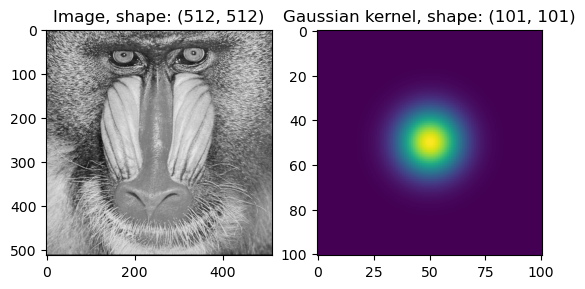

In [2]:
# Import the image 
baboon_gray = imageio.imread("images/baboon.png", pilmode="L")

# Compute a gaussian kernel 
def gaussian_kernel(sigma,n):
    """Returns a n-by-n gaussian kernel (point spread function) with scale sigma.
    Centered when shift=False."""
    indices = np.linspace(-n/2,n/2,n)
    [X,Y]   = np.meshgrid(indices,indices)
    h       = np.exp( -(X**2+Y**2)/(2.0*(sigma)**2) )
    h      /= h.sum() # Normalize
    return h
kernel = gaussian_kernel(10, 101)  

# Make a plot
plt.subplot(121, title="Image, shape: {}".format(baboon_gray.shape))
plt.imshow(baboon_gray, cmap="gray")
plt.subplot(122, title="Gaussian kernel, shape: {}".format(kernel.shape))
plt.imshow(kernel)
plt.show()

<br>
<font size=5 color=#009999> 1.2  Straightforward ("naive") convolution implementation </font> <br>

Define the convolution operation of an $N \times N$ image $f$ with a $k \times k$ kernel $h$ as

$$ (f * h)(i,j) = \sum_{i'=1}^{K} \sum_{j'=1}^K f(i-i',j-j') h(i',j') \quad \forall i,j = 1, ..., N.$$

**Question:** complete the function below which performs the convolution operation (you should read the `scipy.signal` documentation).

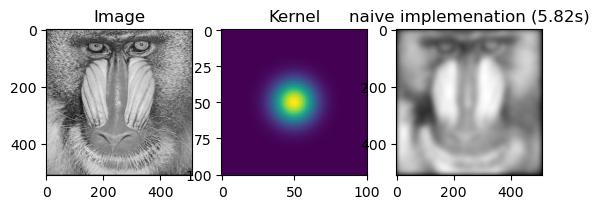

In [6]:
import time
def naive_convolution(image, kernel):
    """The convolution2d function offered with the library scipy.signal has a naive implementation.
    Please use it here to provide a first naive convolution function that conserves image size.
    """
    # Write your implementation here
    
    result = sig.convolve2d(image, kernel, mode="same")
    
    return result


tic = time.time()
naive_result = naive_convolution(baboon_gray, kernel)
tac = time.time()

# Make a plot
plt.subplot(131, title="Image")
plt.imshow(baboon_gray, cmap="gray")
plt.subplot(132, title="Kernel")
plt.imshow(kernel)
plt.subplot(133, title="naive implemenation ({0:.2f}s)".format(tac-tic))
plt.imshow(naive_result, cmap="gray")
plt.show()

<br>
<font size=5 color=#009999> 1.3  Faster implementation </font> <br>

This "straightforward" (one might say, "naive") implementation of the convolution of the $N \times N$ signal $f$ with the $k \times k$ kernel $h$ has complexity $\mathcal{O}(N^2k^2)$, which becomes prohibitive when $k$ is of the order of $N$. Fortunately, a convolution in spatial domain is equivalent to an element-wise multiplication in the Fourier domain ($\odot$ denotes the Hadamard (element-wise) product):

$$f * h = \mathcal{F^{-1}} ( \mathcal{F f} \odot \mathcal{F h} ).$$

<div class="alert alert-block alert-warning">
<b> Computational complextity of the FFT </b> <br>
Computing the convolution this way should bring a large speedup, since the Fast Fourier Transform of an $N \times N$ image has an algorithmic complexity of $\mathcal{O}(N^2\log N^2)$ (we assume for simplicity that $N$ is a power of $2$).
</div>
<br>
   
</div>

**Question:** Can you complete the following code implementing convolution in the Fourier domain?

<div class="alert alert-block alert-info">
<b> Why do we fftshift? </b> <br>
Note that spectrum obtained with the FFT algorithm has a non-intuitive ordering (left part of the figure below).<br> 
This ordering is the following: [0 1 2 3 ... Fs/2   -Fs/2 ... -3 -2 -1]. <br> 

<img src="images/fftshift.png" width = "450"> 
    
`FFTshift` shifts the DC component to the center of the spectrum resulting a 'more intuitive' ordering. This is used mainly to plot signals in the spectral domain. <br> 
This ordering is the following: [-Fs/2 ... -3 -2 -1   0 1 2 3 ... Fs/2]. <br> 

    
Example in shown for a 1-D signal but `fftshift` works in the same manner for 2-D signals (such as images).
</div>
<br>

(512, 512)


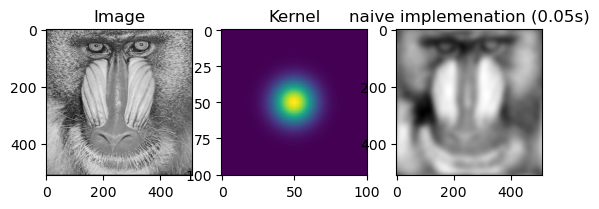

In [28]:
def resize_and_fix_origin(kernel, size):
    """Use zero padding in the fourier domain to obtain a kernel of shape `size`. 
    This is based on the assumption that the kernel is centered in image space (i.e. 'intuitive' ordering).
    A note about this is provided in section 1.5. 
    """
    # Compute the amount of zeros to pad along the border of the kernel
    pad0, pad1   = size[0]-kernel.shape[0], size[1]-kernel.shape[1]
    pad00, pad11 = pad0 - pad0//2, pad1 - pad1//2
    # Zero padding (do not hesitate to visualize the effect of this operation)
    kernel       = np.pad(kernel, ((pad0//2, pad00), (pad1//2, pad11)), mode='constant')      
        # pad 1st axis(x-axis) of the kernel with pad0//2 zeros before and pad00 zeros after the original image
        # pad 2nd axis(y-axis) of the kernel with pad1//2 zeros upper and pad11 zeros below the original image
    # plt.imshow(kernel)
    # change ordering of the spectrum from 'intuitive' to 'FFT'
    kernel       = np.fft.fftshift(kernel)
    # plt.imshow(kernel)
    
    return kernel


def fast_convolution(image, kernel):
    """The library numpy.fft offers functions to implement the fast fourrier transform.
    Please implement a fast convolution algorithm using it.
    
    Be careful! In order to be multiplied elementwise, the Fourier representations have to
    be the same size. Furthermore, a centered kernel will introduce a phase shift in the Fourier
    domain, which introduces a shift in the final result.
    
    In order to cope with those two problems, you can call resize_and_fix_origin defined above.
    """
    # Write your implementation here
    imageFFT = np.fft.fft2(image)
    resized_kernel = resize_and_fix_origin(kernel, image.shape)
    kernelFFT = np.fft.fft2(resized_kernel)
    
    result = np.fft.ifft2(imageFFT * kernelFFT).real
    
    return result


tic = time.time()
naive_result = fast_convolution(baboon_gray, kernel)
tac = time.time()

print(naive_result.shape)

# Make a plot
plt.subplot(131, title="Image")
plt.imshow(baboon_gray, cmap="gray")
plt.subplot(132, title="Kernel")
plt.imshow(kernel)
plt.subplot(133, title="naive implemenation ({0:.2f}s)".format(tac-tic))
plt.imshow(naive_result, cmap="gray")
plt.show()

<br>
<font size=5 color=#009999> 1.4  Comparison between the two methods </font> <br>


After having implemented the fast and naive convolutions, the following cell should show blurry versions of the baboon image.

Do you observe any difference in terms of running time between the two implementations ?

<br>
<font size=5 color=#009999> 1.5  Supplementary note: Why do we shift and/or pad the kernel in 1.3? </font> <br>



/tmp/ipykernel_308065/3685539770.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = 1-(imageio.imread("images/boat.png") > 128).astype(np.uint8)


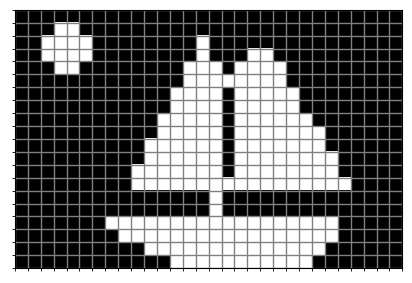

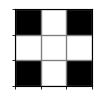

In [ ]:
from TP1_utils import display_pixels

# Let's have a binary image
image = 1-(imageio.imread("images/boat.png") > 128).astype(np.uint8)
display_pixels(plt.figure(figsize=(5,5)).gca(), image)
# ... and a binary kernel
kernel = np.array([[0,1,0],[1,1,1],[0,1,0]])
display_pixels(plt.figure(figsize=(1,1)).gca(), kernel)

To convolve an image with a kernel using FFT, the kernel needs to be padded with 0s to reach the image size. Take the time to understand when we pad or when we shift with the 4 following methods.

<img src='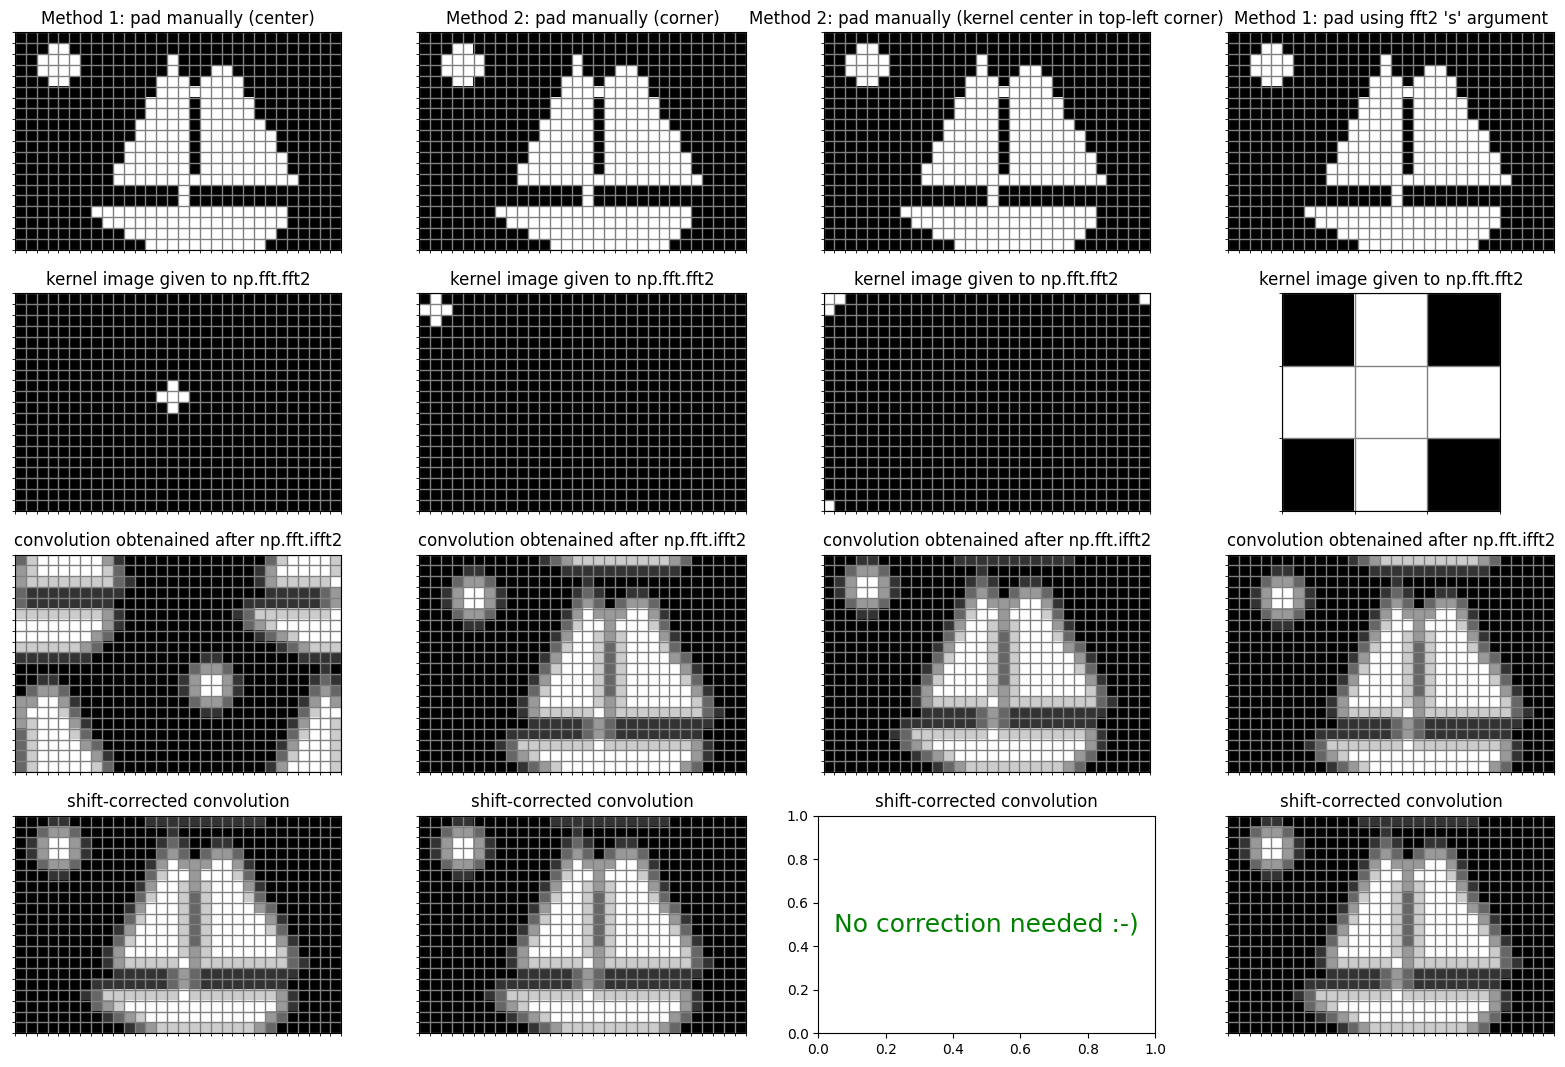
' />

<br>

<font size=6 color=#009999> A MULTI-SCALE REPRESENTATION: THE LAPLACIAN PYRAMID </font> <br>

<br>
<font size=5 color=#009999> 2.1 A brief reminder... </font> <br>

One of the advantages of the Fourier representation of an image is that it allows to easily separate the low-frequency content, i.e., the "smooth content" of the image, from the high-frequency content, i.e., the "details" of the image. However, in the Fourier representation all the spatial information is "mixed up", making it hard for instance to localize objects.

In image processing, we often desire a representation that achieves a tradeoff between accurate frequency and spatial localization. This is the rationale behind time-frequency representations of images: the most basic example of those is the **Laplacian Pyramid Representation**.

<br>
<font size=5 color=#009999> 2.2 Implement a Lapacian Pyramid </font> <br>

The idea is quite simple:

1. Start with $i=0$ and your image at full resolution $I_0$  ($i$ denotes the resolution index).
1. Blur $I_i$ with a gaussian kernel to obtain $B_i$, the blurred image at level $i$.
1. Downsample $B_i$ to obtain $I_{i+1}$, the image at one lower resolution level (without *aliasing* thanks to the blur).
1. *Expand* $I_{i+1}$ back to the resolution $i$ to obtain $I'_{i+1}$, *i.e.,* by zero-padding in the frequency domain.
1. Store the difference $D_i = I_i-I'_{i+1}$. We say that $D_i$ contains the *details* at resolution $i$.
1. Start over at step 2 with $i\gets i+1$ until the resolution level $i$ is "coarse" enough. At the last step $i_{\max}$, also store the coarsest image $I_{i_{\max}}.$ 

This way, when you look at $D_i$, you are able to analyze the *spatial* content of the image at a given *resolution* $i$: the smallest (resp. largest) value of $i$ corresponds to the highest (resp. lowest) frequency content. Let's look at it in practice to understand what's going on.

<img src="images/LaplacianPyramid.png" width = "450">


**Question:** Can you complete the following code ?

<div class="alert alert-block alert-info">
<b> How to ... in python? </b><br> 
Python offers many shortcuts to perform operations in a single line. Did you want to use nested loop to implement the downSampling operation? It will work, but could you find a less verbose method that stands in only 1 line? <br> 
<i> Hint: We use it during TP0... </i>
<br>

In [91]:
def blur(I_i):
    """Blurs the image I_i for the Laplacian pyramid algorithm."""
    B_i = fast_convolution(I_i, gaussian_kernel(10, 101)) # TO COMPLETE
    # Hint: you should use the answer to section 1.3 and the Gaussian filter function we provided
    
    return B_i

def downSample(B_i):
    """Downsamples the image B_i by keeping one pixel out of two samples in each direction).
    This is called 2x2 data binning."""
    I_iplus1 = B_i[0:-1:2, 0:-1:2] # TO COMPLETE
    

    return I_iplus1

def expand(I_iplus1):
    """Upsamples (interpolate on twice the size) I_iplus1 by zero-padding it in the frequency domain."""
    final_shape = I_iplus1.shape[0] * 2, I_iplus1.shape[1] * 2
    
    I_iplus1_fft = np.fft.fft2(I_iplus1)
    I_iplus1_fft_shifted = np.fft.fftshift(I_iplus1_fft)
    
    pad0, pad1 = final_shape[0] - I_iplus1.shape[0], final_shape[1] - I_iplus1.shape[1]
    I_iplus1_fft_padded = np.pad(I_iplus1_fft_shifted, ((pad0//2, pad0//2), (pad1//2, pad1//2)), mode='constant')
    I_iplus1_fft_padded_shifted = np.fft.ifftshift(I_iplus1_fft_padded)
    # print(I_iplus1_fft_padding.shape)
    Iprime_iplus1 = np.fft.ifft2(I_iplus1_fft_padded_shifted) # TO COMPLETE
    
    return Iprime_iplus1.real

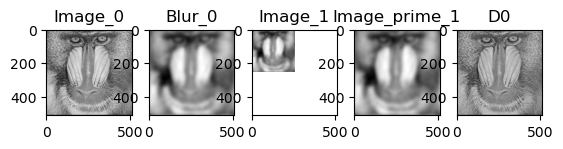

In [93]:
image_0 = baboon_gray 
blur_0 = blur(image_0)
image_1 = downSample(blur_0)
image_prime_1 = expand(image_1)
D_0 = image_0 - image_prime_1

image_width = image_0.shape[1]

plt.figure()
plt.subplot(151, title="Image_0")
plt.imshow(image_0, cmap="gray")
plt.subplot(152, title="Blur_0")
plt.imshow(blur_0, cmap="gray")
plt.subplot(153, title="Image_1")
plt.imshow(image_1, cmap="gray")
plt.xlim(0, image_width)
plt.ylim(image_width, 0)
plt.subplot(154, title="Image_prime_1")
plt.imshow(image_prime_1, cmap="gray")
plt.subplot(155, title="D0")
plt.imshow(D_0, cmap="gray")
plt.show()

**Question:** Can you use the previously written functions to compute the decomposition of the baboon image?

In [ ]:
from TP1_utils import plot_pyramid
# Build a Laplacian pyramid
I_0 = baboon_gray # Some test image here

# Initialization
I_i   = I_0
i_max = 3

plt.imshow(I_i,cmap='gray')
plt.title(r'Original image $I_0$')
plt.show()

pyramid = []

# Build the Pyramid
for i in range(i_max):
    # TO COMPLETE
    
    # Iterate
    I_iMinus1 = I_i
    I_i = downSample(blur(I_i))
    D_i = I_iMinus1 - expand(I_i)
    
    plt.figure(figsize=(10,5))
    plt.subplot(121, title='Image $I_{}$'.format(i+1))
    plt.imshow(I_i,cmap='gray')
    plt.subplot(122, title='Details $D_{}$'.format(i))
    plt.imshow(D_i,cmap='gray')
    plt.colorbar() # Interesting, allows to observe how the details decrease in amplitude
    plt.show()
    
    pyramid.append(D_i)
pyramid.append(I_i)

plt.figure(figsize=(15,8))
plt.title("The complete Laplacian Pyramid")
plot_pyramid(pyramid)
plt.show()

Now, time for some critical thinking. Can you answer the following questions?

**Question 1:** What is the deepest level $i_{\max}$ of the pyramid? Run the pyramid for this value.


**Question 2:** In step 4, why can't we simply take $B_i$ instead of $I'_{i+1}$?

**Question 3:**. Rougly, how large/small should the blur size ($\sigma$) be, e.g., with respect to n? *Hint: think about the Shannon-Nyquist theorem!*

**Question 4:** In the pyramid, we store the details $D_i$ for all $i$ and the lowest resolution image $I_{i_{\max}}$. How can we construct the initial image $I_0$ (and the intermediatry images $I_i$) back from the Laplacian pyramid? Implement this scheme.

In [ ]:
# We encourage you to discuss these on the moodle forum :-) TA will confirm or correct answers given there